# Imports

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import http.client as httplib
from PIL import Image 
import numpy as np
import webcolors
import threading
import argparse
import pathlib
import pickle
import base64
import utils
import time
import json
import ssl
import cv2

# Image bbox coordinates

In [2]:
# This method takes image path as argument and using sighthoundapi
# takes coordinates of licenseplate and returns it
def bbox_image_plate(new_path):
    headers = {"Content-type": "application/json",
               "X-Access-Token": "K4MCUFgx4SogxuEjrt2P5ZVaLNxBR3Tev4F5"}
    conn = httplib.HTTPSConnection("dev.sighthoundapi.com", 
           context=ssl.SSLContext(ssl.PROTOCOL_TLSv1_2))
    
    image_data = base64.b64encode(open(new_path, "rb").read()).decode()

    params = json.dumps({"image": image_data})
    conn.request("POST", "/v1/recognition?objectType=vehicle,licenseplate", params, headers)
    response = conn.getresponse()
    result = response.read()
    
    variables2=json.loads(result)
    try:
        points = variables2['objects'][0]['vehicleAnnotation']['bounding']['vertices']
    except:
        return False, None, None, None, None
    
    return True, points[0]['x'], points[0]['y'], points[1]['x'], points[2]['y']

# precossing data
cropping the image on bbox coordinates

In [3]:
def create_new_image(image_path):
    flag, a, b, c, d = bbox_image_plate(image_path)
    if flag:
        img = Image.open(image_path).crop((a, b, c, d))
        img.save('test.jpg')
    else:
        return False

# Finding closest color
This two method it two find closest color after getting rgb numbers.
We try to convert rgb to real color. If it is not possible, then we
try to find nearest color to that rgb and return it.

In [55]:
my_map = {
"black": "#000000",
"blue": "#0000ff",
"green": '#008000',
"grey": "#808080",
"purple": "#800080",
"red": "#ff0000",
"silver": "#c0c0c0",
"white": "#ffffff"}

In [68]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]


# Trying to use python library webcolors. If rgb is not converted directly to color
# we call closest color method and it returs the color name.
def get_color_name(my_rgb):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(my_rgb)
    except ValueError:
        actual_name, closest_name = None, closest_colour(my_rgb)
        
    return actual_name, closest_name

# Color bar and name
This part of the code it taken from utils project on github. (python library)

In [61]:
def centroid_histogram(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

def plot_colors(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX, names = 0, []
    for (percent, color) in zip(hist, centroids):
        names.append(color)
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype("uint8").tolist(), -1)
        startX = endX
    
    return names[hist.argmax()], bar

# Final method
This is easy method using open cv2 and also clustering alghoritm
we try to cluster given colors on the picture to 3 category. 
After that, we detect their friquency and their color and print it.
We have two kind of output:

1) bar of the colors

2) the closest/real name of the main color

In [62]:
def return_color(path):
    # Crop our picture and save it as ./test.jpg.
    create_new_image(path)
    
    image = cv2.imread('./test.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    shape = image.shape
    image = image.reshape((shape[0] * shape[1], 3))
    
    # Clustering image
    clt = KMeans(n_clusters = 4)
    clt.fit(image)
    
    # take plot and names
    hist = centroid_histogram(clt)
    names, bar = plot_colors(hist, clt.cluster_centers_)
    names = [int(name) for name in names]
    
    print('Showing color bar: ')
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    
    requested_colour = (names[0], names[1], names[2])
    actual_name, closest_name = get_color_name(requested_colour)
    print("Actual color name:", actual_name)
    print("Closest color name:", closest_name)

# Tesing
We need image path and we are ready to go All kinds of examples down below

# 1) Test black car

Showing color bar: 


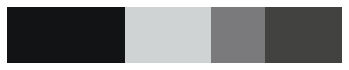

Actual color name: None
Closest color name: black


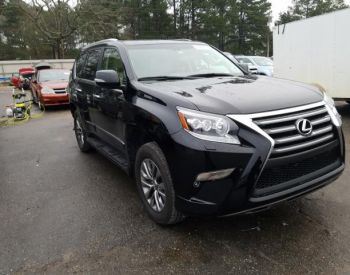

In [63]:
# Image path
path = './data/0.jpg'

img = Image.open(path)
return_color(path)
img

Showing color bar: 


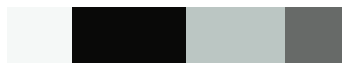

Actual color name: None
Closest color name: black


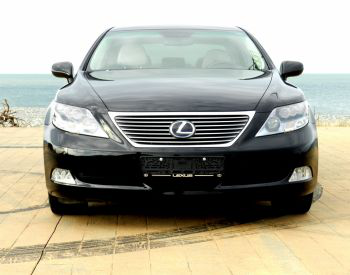

In [64]:
# Image path
path = './data/1.jpg'

img = Image.open(path)
return_color(path)
img

# 1) Test white car

Showing color bar: 


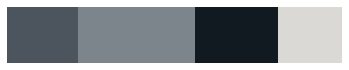

Actual color name: None
Closest color name: grey


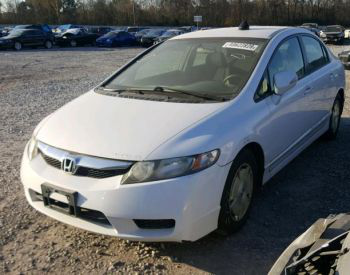

In [65]:
# Image path
path = './data/white/1.jpg'

img = Image.open(path)
return_color(path)
img

Showing color bar: 


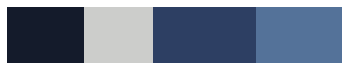

Actual color name: None
Closest color name: darkslategrey


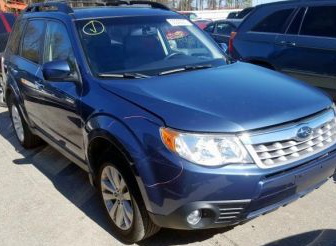

In [70]:
# Image path
path = './data/blue/0.jpg'

img = Image.open(path)
return_color(path)
img

Showing color bar: 


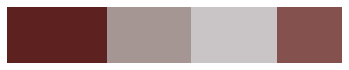

Actual color name: None
Closest color name: maroon


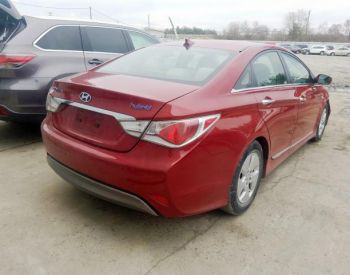

In [69]:
# Image path
path = './data/red/6.jpg'

img = Image.open(path)
return_color(path)
img

Showing color bar: 


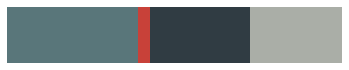

Actual color name: None
Closest color name: dimgrey


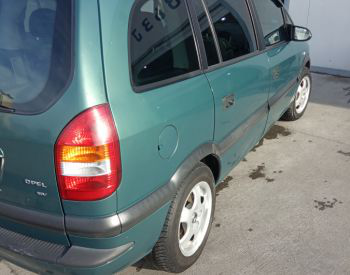

In [71]:
# Image path
path = './data/red/4.jpg'

img = Image.open(path)
return_color(path)
img